# Recommend System

The objective of the project is to determine a selection of 3 movies to recommend for a
particular user.

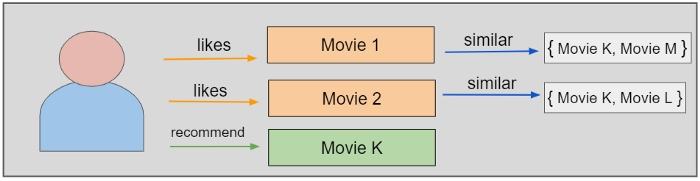

In [1]:
import pandas as pd
import numpy as np

# To split and train our model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# To make the graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Importing data

In [2]:
df_movie_orig = pd.read_csv('movies.csv')
df_rating_orig = pd.read_csv('ratings.csv')

In [3]:
df_movie_orig.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_rating_orig.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


# Pre-processing

In [5]:
# Create columns per movie genre
df_genre = df_movie_orig['genres'].str.get_dummies(sep = '|')
df_genre.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Create columns per movie genre
df_movie = pd.concat([df_movie_orig, df_genre], axis = 1)\
        .drop(['genres', '(no genres listed)'], axis = 1)\
        .rename(columns = {'Film-Noir': 'FilmNoir', 'Sci-Fi': 'SciFi'})

# Create column with the year of the movie, separate old and new movies
df_movie['year'] = df_movie['title'].str.split('(').str[1]
df_movie['year'] = df_movie['title'].str.extract('(\d+)').fillna(0)
df_movie['year'] = df_movie['year'].astype(float).apply(lambda x: 1 if x >= 2000 else 0)
df_movie.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western,year
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Simplify the user rating by having 0 & 1
df_rating = df_rating_orig.drop(['timestamp'], axis = 1)
df_rating['rating_binary'] = df_rating['rating'].apply(lambda x: 1 if x >= 3.5 else 0)
df_rating.head()

,userId,movieId,rating,rating_binary
0,1,16,4.0,1
1,1,24,1.5,0
2,1,32,4.0,1
3,1,47,4.0,1
4,1,50,4.0,1


In [8]:
df = pd.merge(df_rating, df_movie, on = 'movieId')
df.head()

,userId,movieId,rating,rating_binary,title,Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western,year
0,1,16,4.0,1,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,16,4.0,1,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,16,1.5,0,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24,16,4.0,1,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29,16,3.0,0,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Create two columns to have more informaitons about the movie
df_mean = df[['movieId', 'rating']].groupby('movieId').agg(['count', 'mean'])
df_mean.columns = ['count', 'mean']
df_mean['mean'] = round(df_mean['mean'], 2)
df = pd.merge(df, df_mean, on = 'movieId')

# A dataframe for training & test
df.head()

,userId,movieId,rating,rating_binary,title,Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,SciFi,Thriller,War,Western,year,count,mean
0,1,16,4.0,1,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,84,3.79
1,9,16,4.0,1,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,84,3.79
2,12,16,1.5,0,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,84,3.79
3,24,16,4.0,1,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,84,3.79
4,29,16,3.0,0,Casino (1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,84,3.79


# Creating a good movie table

In [10]:
# Filter movies with an average rating >= 3.5, to reduce the calculation
# Filter movies with number of rating >= 10
df_rating_mean = df_rating_orig.drop(['userId', 'timestamp'], axis = 1)\
        .groupby('movieId').agg(['count', 'mean']).reset_index()
df_rating_mean.columns = ['movieId','count', 'mean']
df_rating_mean['mean'] = round(df_rating_mean['mean'], 1)
df_filtered = df_rating_mean.loc[(df_rating_mean['mean'] >= 3.5) & (df_rating_mean['count'] >= 10)]

# A dataframe of candidate movies
df_good_movie = pd.merge(df_movie, df_filtered, on = 'movieId')
df_good_movie.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,SciFi,Thriller,War,Western,year,count,mean
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,232,3.9
1,6,Heat (1995),1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,115,4.1
2,10,GoldenEye (1995),1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,135,3.6
3,11,"American President, The (1995)",0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,85,3.7
4,14,Nixon (1995),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,25,3.5


# Model: Logistic Regression

In [11]:
# Define a recommend system function
def Recommend_system(userId):
    
    #Step 1: Creating the features and label, and then spliting our data
    df_user = df.loc[df['userId'] == userId]

    features = df_user.loc[:,'Action':'year'].values.tolist()
    label = df_user['rating_binary'].tolist()
    x_train, x_test, y_train, y_test = train_test_split(features, label,
                                                        test_size = 0.25, random_state = 0)

    #Step 2: Use logistic regression to do the user's preference training
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_train, y_train)

    #Step3: Calculate the accuracy of the model
    y_pred = logisticRegr.predict(x_test)
    score = logisticRegr.score(x_test, y_test)

    #Step 4: Make a user's preference prediction with the model
    df_good_m = df_good_movie.loc[df_good_movie['movieId'].isin(df.loc[df['userId'] == userId, 'movieId']) == False]
    preference_pred = logisticRegr.predict(df_good_m.loc[:,'Action':'year'].values.tolist())
    df_movie_prefer = df_good_movie.copy()
    df_movie_prefer['preference'] = pd.DataFrame(preference_pred)

    #Step5: Filter the candidate movies by the prediction, and select 3 unwatched movies with top ratings
    df_final = df_movie_prefer.loc[df_movie_prefer['preference'] == 1]
    df_final_2 = df_final.loc[df_final['movieId'].isin(df_user['movieId']) == False]\
            .sort_values(by = ['mean'], ascending = False)[['mean', 'title']]\
            .reset_index(drop =True).head(3)

    #Step 6: Printing our results
    print(f'\n3 movies recommended for userId: {userId},\nwho has given ratings for {len(df_user)} movies.')
    display(df_final_2)
    
    #Step 7: Creating a matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (6, 6))
    sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = 0.5, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = f'Model Accuracy Score: {round(score * 100, 1)}%'
    plt.title(all_sample_title, size = 12)
    plt.savefig('Movies_ConfusionSeabornCodementor.png')
    plt.show()

# Result: Movies Recommended


3 movies recommended for userId: 120,
who has given ratings for 46 movies.


,mean,title
0,4.5,All Quiet on the Western Front (1930)
1,4.5,"Shawshank Redemption, The (1994)"
2,4.5,Creature Comforts (1989)


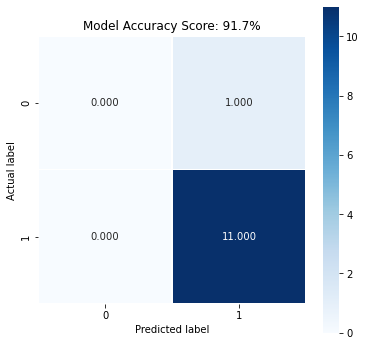

In [12]:
# Run the system
# Enter the user ID, from 1 to 668
userId = 120
Recommend_system(userId)

# For some users who didn't give enough number of rating,
# low model accuracy or empty recommendation may occur.